# Optimizing Restaurant Inspection Frequency Based on Violations Cited

# Overview

In this project, I explored the relationship between the days since a restaurant's last inspection and the difference in violations cited between their recent and previous inspections. Based on data of North Carolina restaurant inspections, analysis was carried out and in the end, it was inconclusive whether or not such a day exists. 

# Name & GitHub

- Name: Calvin Chen
- GitHub Username: carbonchen

# Research Question

Based on the days passed since a restaurant's previous inspection and the difference in violations cited between their recent and previous inspections, can we figure out the optimal number of days restaurant inspections should be done from each other?

## Background and Prior Work

Food safety often doesn't come to mind when you think about public wellbeing. However, the Centers for Disease Control and Prevention (CDC) estimates that foodborne illness affects about 48 million Americans and is responsible for about 3,000 deaths annually in the US (1). Finding a way to improve the restaurant health inspection process is a good step to helping prevent the nearly 500,000 annual foodborne-related hospitalizations and save the nation billions in medical costs. 

Several studies have been conducted on the effect of inspection frequency on restaurant sanitation in the past. One such study found that reducing inspection frequencies from quarterly to yearly resulted in declining sanitation standards across all categories of food service establishments (2). Another study reached similar conclusions: restaurant violation scores worsened when the time since last inspection was greater than 12 months, but did not worsen when the interval was shorter (3). 

Based on these findings, it may be possible to figure out an optimal number of days apart inspections should be done from each other. If so, it may prove to be incredibly beneficial in preventing foodborne disease.


References:
- 1) [Estimates of Foodborne Illness in the United States](https://www.cdc.gov/foodborneburden/2011-foodborne-estimates.html)
- 2) [A study of food service establishment sanitation inspection frequency.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1653943/)
- 3) [The Effects of Inspection Frequency and Food Handler Education on Restaurant Inspection Violations](https://pubmed.ncbi.nlm.nih.gov/7728716/)

# Hypothesis


Based on the previous studies's findings, restaurant inspections should be done at least annually. At the same time, overly frequent inspections doesn't seem optimal, so personal logic leads me to believe that inspections should be done every 6 months.

# Dataset(s)

- Dataset Name: inspections
- Number of observations: 18466
 
This file contains data of restaurants in North Carolina and their inspection histories. Data regarding the violations from the recent as well as previous inspections will be of particular importance to this analysis.

# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Cleaning

First we will load in the csv file as a Pandas dataframe object. Then, let's take a peek at the head of the data.

In [2]:
df = pd.read_csv('inspections.csv')
df.head()

,hsisid,date,name,address1,address2,city,state,postalcode,phonenumber,restaurantopendate,...,num_non_critical,num_critical_previous,num_non_critical_previous,num_critical_mean_previous,num_non_critical_mean_previous,avg_neighbor_num_critical,avg_neighbor_num_non_critical,top_match,second_match,critical
0,4092013748,2012-09-21T00:00:00Z,Cafe 3000 At Wake Med,3000 New Bern Ave,NaN,raleigh,NC,27610,(919) 350-8047,2002-12-21T00:00:00Z,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,4092014046,2012-09-21T00:00:00Z,Overtime Sports Pub,1030-149 N Rogers Ln,NaN,raleigh,NC,27610,(919) 255-9556,2004-05-04T00:00:00Z,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4092015191,2012-09-21T00:00:00Z,TASTE OF CHINA,6209 ROCK QUARRY RD,STE 126,raleigh,NC,27610,(919) 773-2285,2008-08-04T00:00:00Z,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,4092016122,2012-09-21T00:00:00Z,Panera Bread #1643,1065 Darrington DR,NaN,cary,NC,27513,NaN,2012-03-28T00:00:00Z,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,4092021513,2012-09-21T00:00:00Z,WalMart Supercenter #4499-00 Deli/Bakery,841 E Gannon AVE,NaN,zebulon,NC,27597,(919) 269-2221 ext. 304,2008-02-25T00:00:00Z,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


There are only a few columns relevant to the analysis, so let's reduce the dataframe to only these columns:
- days_since_last_inspection
- num_critical
- num_non_critical
- num_critical_previous
- num_non_critical_previous

Since these column names appear clean, we will keep them as is.

In [3]:
df = df[["days_since_previous_inspection", "num_critical", "num_non_critical", "num_critical_previous", "num_non_critical_previous"]]
df.head()

,days_since_previous_inspection,num_critical,num_non_critical,num_critical_previous,num_non_critical_previous
0,NaN,9,7,NaN,NaN
1,NaN,0,11,NaN,NaN
2,NaN,4,8,NaN,NaN
3,NaN,2,3,NaN,NaN
4,NaN,2,4,NaN,NaN


Now, let's remove the observations where there is missing data from the previous inspection. These restaurants will not be helpful in our analysis since we are trying to compare recent and previous inspection data.

We will also reset the row indices for consistency.

In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Data Analysis & Results

Before beginning analysis, we need to compute a column representing the difference in violations between the current inspection and the previous inspection. This tells us whether or not the restaurant has improved their sanitation standards since their last inspection. 

In this case, we will be treating critical and non-critical violations the as the same. For each observation, we will subtract the previous inpection's critical/non-critical/total violations from the recent inspection's violations and store them in new columns, "diff_critical," "diff_non_critical," and "diff_total."

In [5]:
df['diff_critical'] = df['num_critical'] - df['num_critical_previous']
df['diff_non_critical'] = df['num_non_critical'] - df['num_non_critical_previous']
df['diff_total'] = (df['num_critical'] + df['num_non_critical']) - (df['num_critical_previous'] + df['num_non_critical_previous'])

Let's first visualize a scatterplot with days_since_last_inspection as the independent variable and diff_total as the dependent variable. 

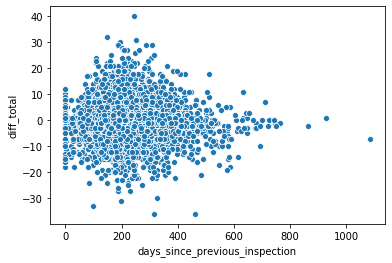

In [6]:
sns.scatterplot(df['days_since_previous_inspection'], df['diff_total'])

If we also visualize days_since_previous_inspection vs. diff_critical (orange) and days_since_previous_inspection vs. diff_non_critical (green) on top of this, we see that they all follow the same general trend.

Because of this, we will focus analysis on total violations for a more general view on the data

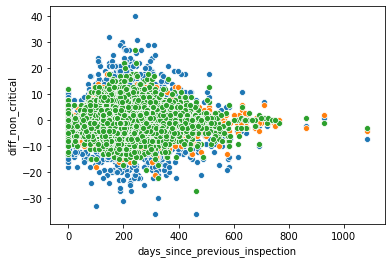

In [7]:
sns.scatterplot(df['days_since_previous_inspection'], df['diff_total'])
sns.scatterplot(df['days_since_previous_inspection'], df['diff_critical'])
sns.scatterplot(df['days_since_previous_inspection'], df['diff_non_critical'])

There seems to be a particularly large variance in number of violations at around the 200 day mark. Let's compute an absolute value column of "diff_total" and see the magnitude of changes in number of violations for each day. 

Optimally, we want the absolute value difference in violations to be close to 0. This means that there were little to no differences in number of citations between the previous and recent inspections. Of course, a restaurant could have 50 violations previously and 50 violations recently, but larger numbers seem unlikely because the restaurant's goal is to reduce citations for the next inspection. Therefore, with a low absolute value difference, it is logical to assume the restaurant had low numbers of violations.

Having computed the absolute values, let's also visualize it on a scatter plot.

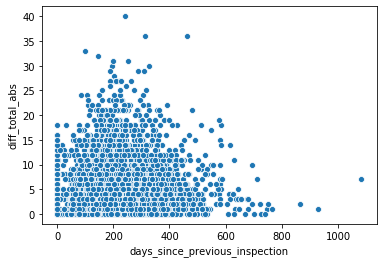

In [8]:
df['diff_total_abs'] = abs(df['diff_total'])
sns.scatterplot(df['days_since_previous_inspection'], df['diff_total_abs'])

As expected, there is a peak in the scatter plot at around 200 days. This means the restaurants have a particularly large difference in violations between their recent and previous inspections if about 200 days have passed since the previous inspection. This leads me to believe inspections should at least be done every 200 days to prevent such a huge difference in sanitation standards.

Exploring further, let's compute the mean diff_total_abs for each day and visualize it on a scatter plot with a linear line of best fit.

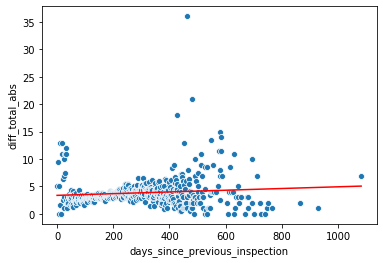

In [9]:
df = df.groupby(['days_since_previous_inspection']).mean()
sns.scatterplot(df.index, df['diff_total_abs'])

a1, b1 = np.polyfit(df.index, df['diff_total_abs'], 1)
xs = np.arange(df.index.min(), df.index.max())
ys = a1 * xs + b1
plt.plot(xs, ys, color='red')

Unfortunately, my previous belief that the 200-day mark is dispelled by this graph; there is actually a low difference in citations between restaurants' previous and recent inspections. 

Based on the line of best fit, there also seems to be no significant relationship between the days passed and the difference in citations. 

There are still a couple points we can draw from this graph:
- 1) There is a particularly large variance in difference in citations for inspections that were done close to each other. This leads me to believe that on the previous inspection, many critical violations were cited, so another visit soon after would be needed to ensure those violations were taken care of. On the second inspection, these violations were likely fixed, so the absolute value difference in number of citations appear to be high.
- 2) It seems that restaurant inspections are often done 200 days apart from each other in North Caroline since there is a majority cluster of points surrounding that day. Furthermore, the mean citation differences appear quite low for those inspections, hovering around a difference of 3-4 citations. This leads me to believe that restaurants are aware of this schedule and likely prepare for the inspections. 
- 3) Although the line of best fit may not support it, visually, we see that as time passes, the difference in citations appear to increase while also varying wildly. This tells us that past 600 days since the previous inspection, the recent state of the restaurants' health standards are very different from when they were previously inspected, whether for good or for worse. 

Although it may not be entirely clear whether or not there exists an optimal day for which inspections should be done apart from each other, the graph suggests that as long as the days since the previous inspection doesn't pass 400, the restaurant should be relatively consistent in terms of sanitation standards.

# Ethics & Privacy

Since only data on the violations cited and the dates on the inspections were used, no personal information of any kind was disclosed. This includes the protection of restaurant names, locations, contact info, as well as info on who conducted the inspections. As such, it is difficult to believe somebody could extract personal data for ill purposes from the analysis.

Ethically, the results of this project could potentially be used for ill purposes. For example, the state of Carolina, seeing my conclusion, may conclude that restaurant inspections should not be done unless 400 days have passed since the previous inspection. After all, inspections do cost money. This may put North Carolina residents at higher risk for catching foodborne disease. In response, I propose that since the findings of this report were not too strong, these results should only be used as a guideline for more extensive analysis that can be done in the future. 

# Conclusion & Discussion

In this project, the relationship between the days since a restaurant's last inspection and the difference in violations cited between their recent and previous inspections was explored. I hypothesized that inspections should be done 6 months apart from each other based on past research on the same topic. Using data of restaurant inspections from North Carolina, scatter plots of time since last inspection and difference in citations were analyzed to see if there exists an optimal day that inspection schedules should be set apart from each other. In the end, my hypothesis was rejected, and it was inconclusive whether such an optimal day exists. However, we did find that as long as the previous inspection doesn't pass 400 days since the next inspection, santitation standards should be consistently protected. 

Furthermore, these results can only be generalized to restaurants in North Carolina. Health standards vary from across states and even counties. As such, it may be dangerous to conclude that it would be fine if restaurant inspections were done 200 days apart for California restaurants. It is almost certain that California has different standards. In fact, the health standards  are probably stricter since there's a higher population, and with higher population, it may be more easy for foodborne illness to spread. 

On that note, an analysis similar to this project could be done for all states in the US to see if an optimal inspection schedule can be deduced. If so, it would certainly be a good step towards combatting foodborne illness.